## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

> In this project, we will be working to understand the results of an A/B test run by an e-commerce website. The test wil be run to compare the performance of the old version of website to the new version using bootstrapping for hypothesis testing.

<a id='probability'></a>
### Part I - Probability

> We will start off by importing our required libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

We will now, read in the csv file and print out few of it's lines. 

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


We will use the shape function to know the row size of the database.

In [4]:
df.shape

(294478, 5)

The number of unique users in the dataset will be found out by checking the unique number of user_id's present in the dataset.

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

We will find the proportion of converted users by making a new dataframe and then find out the number of converts.Then we will find the percentage of converts from the total number of unique users.

In [6]:
convert=df.query('converted == 1')

In [7]:
convert.shape

(35237, 5)

In [8]:
35237/290584

0.12126269856564711

In this step we will find out the number of landing pages which are not new page and is assigned to the treatment group,then we will find the number of new pages allotted to the control group and add both of these to find the total number of mismatched pages. 

In [9]:
treatment=df.query('landing_page !="new_page" and group== "treatment"')
treatment.shape

(1965, 5)

In [10]:
control=df.query('landing_page=="new_page" and group=="control"  ')
control.shape

(1928, 5)

In [11]:
treatment.shape[0]+control.shape[0]

3893

In the next step we will find out if there are number of missing values in any rows.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The mis-matched rows will be dropped because these are uninterpretable and the rest of the rows will be added in a new dataframe.

In [13]:
delete=treatment.append(control).index

In [14]:
df2=df.drop(delete)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
df2.shape

(290585, 5)

In [16]:
# Double Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

The unique users in the newly dataframe is checked through the nunique function.

In [17]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

We observed that the number of number of unique userid's is one less than the total number of id's and hence one of these is a duplicate id.

We will find out which of the id is duplicate and print the details of that row.

In [18]:
duplicate = df2[df2.duplicated(['user_id'])]

In [19]:
duplicate.head()

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The duplicated row will be dropped from the dataframe.

In [20]:
df2.drop(2893, inplace=True)

We will check the converted mean once again for the updated dataframe.

In [21]:
df2.converted.mean()

0.11959708724499628

We will find the conversion rate for the old page.

In [22]:
converted_control = df2[df2['group'] == 'control']['converted'].mean()
print(converted_control)

0.1203863045


We will also find the conversiopn rate for the new page.

In [23]:
converted_treatment= df2[df2['group'] == 'treatment']['converted'].mean()
print(converted_treatment)

0.118808065515


In the end,the probability of getting the new page will be found out

In [24]:
new_page_probable = (df2['landing_page'] == 'new_page').mean()
print(new_page_probable)

0.500061944223


Both the pages are well proportioned and balanced therefore no additional changes is needed to maintain the balance unevenness between the pages.

**Observation:** The following results state that the data is not sufficient for us to come to the conclusion that the treatment page leads to more conversions as the probability of conversion from treatment group is less than that of control group.

<a id='ab_test'></a>
### Part II - A/B Test

**Hypothesis** 
$$
H_0 : p_{new} - p_{old} \leq 0 \\
H_1 : p_{new} - p_{old} > 0
$$

Conversion rate for $p_{new}$ and $p_{new}$ under the null hypothesis would be the same and hence can be calculated by:-

In [25]:
df2.converted.mean()

0.11959708724499628

We will find $n_{new}$, which is the number of individuals in the treatment group

In [26]:
n_new = df2.query('landing_page == "new_page"')
n_new.shape

(145310, 5)

We will also find $n_{old}$, the number of individuals in the control group

In [27]:
n_old = df2.query('landing_page == "old_page"')
n_old.shape

(145274, 5)

The conversion rate for the new page will be found out.

In [28]:
convert_mean = df2.converted.mean()
print(convert_mean)

0.119597087245


In [29]:
new_page_converted=np.random.choice([0,1],size=n_new.shape[0], p=[(1 - convert_mean), convert_mean])

Simulate the conversion rate for the old page as well.

In [30]:
old_page_converted = np.random.choice([0, 1], size=n_old.shape[0], p=[(1 - convert_mean), convert_mean])

The difference between the conversion rates will be found out.

In [31]:
new_page_converted.mean() - old_page_converted.mean()

-2.2699542195844802e-05

We will run 10,000 simulations

In [32]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new.shape[0], p=[(1 - convert_mean), convert_mean])
    old_page_converted = np.random.choice([0, 1], size=n_old.shape[0], p=[(1 - convert_mean), convert_mean])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

Plot the histogram of the p_diffs.

In [33]:
p_diffs = np.asarray(p_diffs)

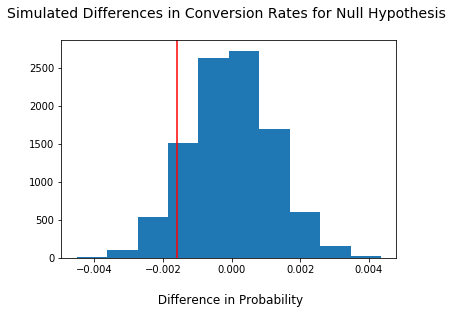

In [34]:
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis \n", fontsize=14)
plt.xlabel("\n Difference in Probability", fontsize=12)
plt.axvline(converted_treatment - converted_control, color='red');

We will check which proportion of the p_diffs is actually greater than the actual difference.

In [35]:
obs_diff = converted_treatment - converted_control

(p_diffs > obs_diff).mean()

0.90139999999999998

**Results:** The p-value calculated is 0.9010. This is very much greater than the typical $\alpha$ level of 0.05 in business studies. (An $\alpha$ level of 0.05 indicates that we have a 5% chance of committing a Type I error if the null is true.) As such, we would fail to reject the null and state that the data is insufficient and it can be said that that there is a difference between the two values.

#### Comparison to built in t-test

To Calculate the number of rows for old and new.

In [36]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


we will now use stats.proportions_ztest to compute our test statistic and p-value.

In [37]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new.shape[0], n_old.shape[0]], alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

We observe from the above approaches that the calculated values match with those found during the bootstrapped hypothesis testing.

<a id='regression'></a>
### Part III - A regression approach


#### Logistic Regression

The first step would be to create the dummy variables and add an intercept.

In [38]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


The next step would be to instantiate and fit the model.

In [39]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


We will use **statsmodels** to instantiate your regression model on the columns we created and then fit the model using the columns to predict whether or not an individual converts. 

In [40]:
# Workaround for known bug with .summary() with updated scipy
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 01 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        06:08:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The z-score tells us about how many standard deviations our data is away from the mean.Here the z-score(-1.311) means that it is -1.311 standard deviations below from the mean of the data which is in the satisfatory range of the z-score. 

The p-value (0.190) here remains above an $\alpha$ level of 0.05 but is not the same because this is a two tailed test. We will still not accept the null in this situation.

We will see this with the bootstrapped information:

In [41]:
# Calculate area of lower tail
p_lower = (p_diffs < obs_diff).mean()

# Calculate area of upper tail
upper = p_diffs.mean() - obs_diff
p_upper = (p_diffs > upper).mean()

# Calculate total tail area
p_lower + p_upper

0.19519999999999998

We will now add an additional variable to the model to check if that is statistically significant to our regression analysis.Adding more variables to the regression analysis gives a new term for the model to fit and a new co-efficient that it can vary to force a better fit.

We should keep in mind not to add too many additional variables to our regression model as this will more and more likely overfit our model which is not deseriable. 

#### Add an additional variable to the model

More information regarding conversion rates is available for user country. The model is tested to see if there is a connection between the country of the user and the conversion rates between the old and new pages.

In [42]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


We will confirm the countries of the users.

In [43]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

The next step would be to build the dummy variables.

In [44]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


Instatiate and fit the model.

In [45]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        06:08:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**Results:** Once again, the p-values for hte countries are well above a 0.05 $\alpha$ level. And so we fail to reject the null and come to the conclusion that on it's own, there is no considerable contribution from countries to differences in conversion rates for the following two pages.

Now we will check the following for an interaction.
We will repeat the same steps as above.

In [46]:
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [47]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 01 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        06:08:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**Results:** In this case we can see that neither of the variables have considerable p-values. Therefore, we will fail to reject the null and come to the conclusion that there is not sufficient evidence to come that there is an interaction between country and page received that will predict whether a user will convert or not.

In the bigger picture, based on the information from the data, we don't have adequate proof to state that the new page brings about a greater number of conversions than the old page. 

In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0